In [1]:
import pyodbc
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
#from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
#stop = set(stopwords.words('english'))
import os
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import json
import ast 
from urllib.request import urlopen
from PIL import Image


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DUSHI-DELL\SQLEXPRESS;"
                      "Database=BoxOffice;"
                      "Trusted_Connection=yes;")

In [3]:
ff = pd.read_sql("SELECT * FROM movies_ff_v ;",cnxn) 
ff.head()

,movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,release_year,release_month,high_release_month,release_day,seasonality,sw_collection,producers_cnt,countries_cnt,lang_US,lang_FR,lang_RU,lang_ES,lang_JA,keywords_cnt,actor0_movies_cnt,actor0_movies_5y_cnt,actor1_movies_cnt,actor1_movies_5y_cnt,actor2_movies_cnt,actor2_movies_5y_cnt,sw_female_actor0,sw_female_actor1,sw_female_actor2,sw_male_actor0,sw_male_actor1,sw_male_actor2,actor0_prev_revenue,actor1_prev_revenue,actor2_prev_revenue,director_movies_cnt,director_movies_5y_cnt,genre_adventure,genre_fantasy,genre_animation,genre_drama,genre_horror,genre_action,genre_comedy,genre_history,genre_western,genre_thriller,genre_crime,genre_documentary,genre_science_fiction,genre_mystery,genre_music,genre_romance,genre_family,genre_war,genre_foreign,depart_Art,depart_Camera,depart_Crew,depart_Custom_Mkup,depart_Directing,depart_Editing,depart_Lighting,depart_Production,depart_Sound,depart_Visual_Effects,depart_Writing,depart_Art_female,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
0,1,14000000,en,6.575393,2015-02-20,93.0,Short,12314651.0,1,0,1,1,4,2015.0,2.0,0,20.0,-15309317.0,0,3.0,1,1,0,0,0,0,4,18,11,13,4,8,6,0.0,0.0,0.0,1.0,1.0,1.0,116980662.0,219076518.0,121463226.0,3,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,12.0,8.0,4.0,13.0,4.0,2.0,4.0,9.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,40000000,en,8.248895,2004-08-06,113.0,Medium,95149435.0,1,0,1,1,4,2004.0,8.0,1,6.0,-33273015.0,0,1.0,1,1,0,0,0,0,4,3,3,10,2,13,4,1.0,1.0,0.0,0.0,0.0,1.0,165335153.0,165335153.0,309457509.0,9,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
2,3,3300000,en,64.299990,2014-10-10,105.0,Medium,13092000.0,1,1,1,1,12,2014.0,10.0,1,10.0,-28659422.0,0,3.0,1,1,0,0,0,0,12,7,7,34,11,0,0,0.0,0.0,1.0,1.0,1.0,0.0,48065672.0,231411584.0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,4.0,9.0,5.0,3.0,6.0,1.0,18.0,9.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,4,1200000,hi,3.174936,2012-03-09,122.0,Large,16000000.0,0,1,1,0,7,2012.0,3.0,0,9.0,-7149862.0,0,NaN,1,1,0,0,0,0,7,2,1,2,2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,4100000.0,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,ko,1.148070,2009-02-05,118.0,Medium,3923970.0,0,0,1,0,0,2009.0,2.0,0,5.0,-15309317.0,0,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualizing the target distribution

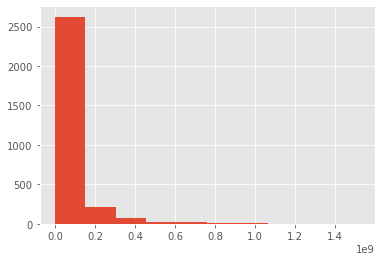

In [5]:
ff.revenue.hist();

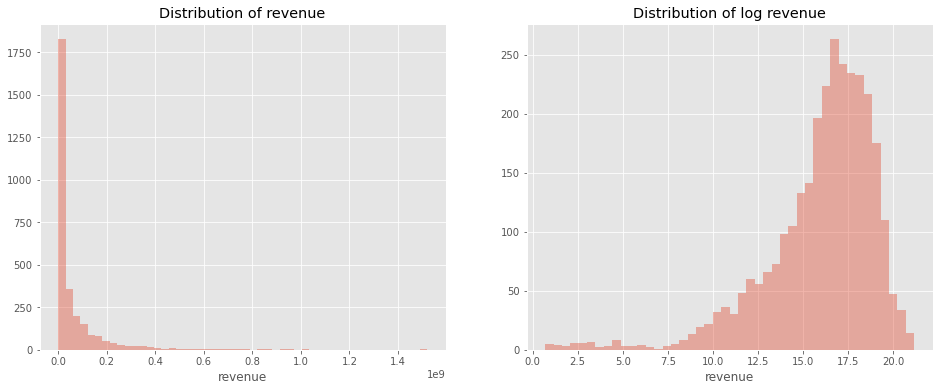

In [7]:
fig, ax=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(ff['revenue'],kde=False);
plt.title('Distribution of revenue');
plt.subplot(1,2,2)
sns.distplot(np.log1p(ff['revenue']),kde=False);
plt.title('Distribution of log revenue');

In [8]:
ff['log_revenue']=np.log1p(ff['revenue'])

### Relationship between Film Revenue and Budget

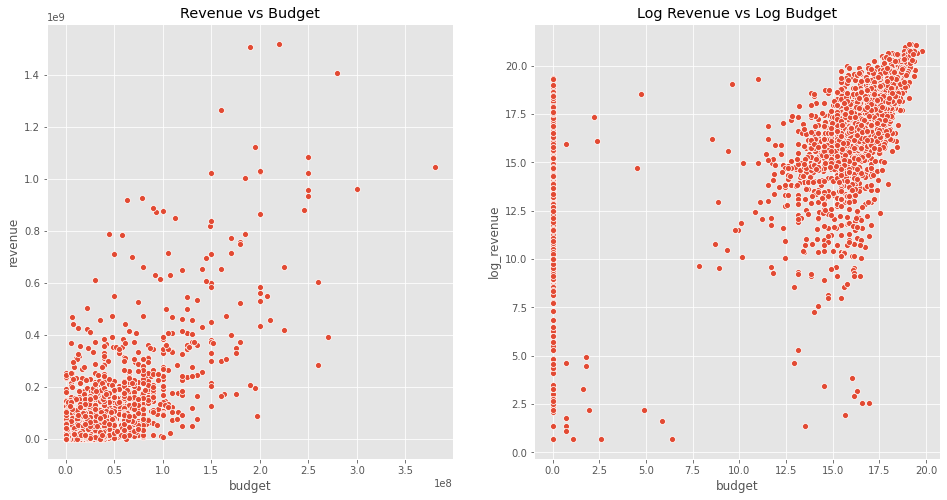

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(ff['budget'],ff['revenue'])
plt.title('Revenue vs Budget');
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(ff['budget']),ff['log_revenue'])
plt.title('Log Revenue vs Log Budget');

In [11]:
ff['log_budget']=np.log1p(ff['budget'])

In the plot you can see, there is a corellation between budget and revenue.the budget of movies affests their revenue.

### Does having an official homepage affect revenue

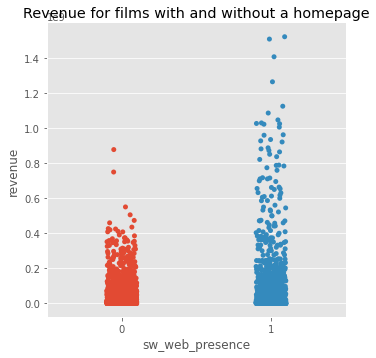

In [12]:
sns.catplot(x='sw_web_presence', y='revenue', data=ff);
plt.title('Revenue for films with and without a homepage');

films with homepage tend to generate more revenue as you can see on the y axis. maybe people may to get know more broadly about the film with officiale website.

### Distribution of languages in film

locate top 10 occuring languages in this colume

In [19]:
language_data=ff.loc[ff['original_language'].isin(ff['original_language'].value_counts().head(10).index)]

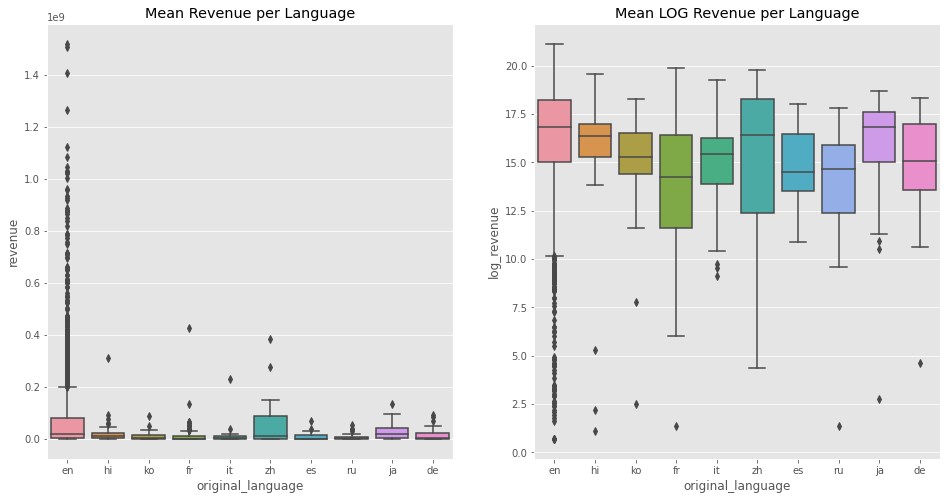

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.boxplot(x='original_language', y='revenue', data=language_data)
plt.title ('Mean Revenue per Language');
plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data)
plt.title ('Mean LOG Revenue per Language');

seems that English overshadows all the other languages, with highest revenue, 
but the log transformation on the right that other films on other languages generates high revenue. 
But English is the winner in maximum revenue


### Common Words in Film Titles and Descriptions